# Machine Learning Experiment - Exploratory Data Analysis
# Comprehensive performance comparison across multiple models and folds

## Setup and Imports

In [ ]:

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from typing import List, Dict, Tuple, Union
import re
import os

warnings.filterwarnings('ignore')

# Set style for professional, modern visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.2)

# Configure matplotlib for high-quality outputs
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Show all rows
pd.set_option("display.max_rows", 1000)

# Show all columns
pd.set_option("display.max_columns", 27)

# Create output directory for images
output_dir = Path("results/images/baselines")
output_dir.mkdir(parents=True, exist_ok=True)

print("✅ Setup complete - Ready for analysis")

# Define color palette
COLORS = {
    "red": "#c94c4c",
    "orange": "#cf8532",
    "purple": "#786797",
    "gray": "#363636",
    "blue": "#406c80",
    "green": "#2B6327",
}

## Data Loading Functions

def load_fold_results(model_spec: Union[str, Tuple[str, str]], results_dir: str = "results") -> pd.DataFrame:
    """
    Load validation results for all folds of a specific model.
    
    Parameters:
    -----------
    model_spec : str or Tuple[str, str]
        Either a model name (str) or a tuple of (model_name, run_code)
        If tuple, only loads results matching the run_code pattern
    results_dir : str
        Base directory containing results
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing all metrics for all folds and classes
    """
    # Parse model specification
    if isinstance(model_spec, tuple):
        model_name, run_code = model_spec
        filter_by_run = True
    else:
        model_name = model_spec
        run_code = None
        filter_by_run = False
    
    val_path = Path(results_dir) / model_name / "val"
    
    if not val_path.exists():
        raise ValueError(f"Validation directory not found: {val_path}")
    
    # Find all result files
    result_files = sorted(val_path.glob("*_results.pt"))
    
    if not result_files:
        raise ValueError(f"No result files found in {val_path}")
    
    # Filter by run_code if specified
    if filter_by_run:
        filtered_files = []
        for file_path in result_files:
            # Check if run_code is in the filename
            if run_code in file_path.name:
                filtered_files.append(file_path)
        
        if not filtered_files:
            raise ValueError(f"No result files found matching run_code '{run_code}' in {val_path}")
        
        result_files = filtered_files
        print(f"   Filtering by run_code: '{run_code}' - Found {len(result_files)} matching files")
    
    all_data = []
    
    for file_path in result_files:
        # Extract fold number from filename
        fold_match = re.search(r'fold(\d+)', file_path.name)
        if not fold_match:
            continue
            
        fold_num = int(fold_match.group(1))
        
        # Load PyTorch file
        result_data = torch.load(file_path, map_location='cpu')
        
        if result_data.get('status') != 'success':
            print(f"⚠️  Warning: Fold {fold_num} status is not 'success'")
            continue
        
        class_logs = result_data.get('class_logs', {})
        
        # Extract per-class metrics
        for key, value in class_logs.items():
            # Parse key: fold{X}/metric_classname or fold{X}/metric_mean
            parts = key.split('/')
            if len(parts) != 2:
                continue
                
            fold_part, metric_part = parts
            
            # Extract metric and class name
            metric_split = metric_part.split('_', 1)
            if len(metric_split) == 2:
                metric_name, class_name = metric_split
            else:
                continue
            
            all_data.append({
                'model': model_name,
                'fold': fold_num,
                'class': class_name,
                'metric': metric_name,
                'value': float(value)
            })
    
    if not all_data:
        raise ValueError(f"No data could be extracted from result files in {val_path}")
    
    df = pd.DataFrame(all_data)
    
    if filter_by_run:
        print(f"✅ Loaded {len(result_files)} folds for model '{model_name}' (run: {run_code})")
    else:
        print(f"✅ Loaded {len(result_files)} folds for model '{model_name}'")
    
    print(f"   Total records: {len(df)} | Classes: {df['class'].nunique()} | Metrics: {df['metric'].nunique()}")
    
    return df


def load_multiple_models(model_specs: List[Union[str, Tuple[str, str]]], results_dir: str = "results") -> pd.DataFrame:
    """
    Load validation results for multiple models and combine them.
    
    Parameters:
    -----------uv create jupyter venv
    model_specs : List[Union[str, Tuple[str, str]]]
        List of model specifications. Each can be either:
        - A string: model name (loads all runs)
        - A tuple: (model_name, run_code) (loads only specific run)
    results_dir : str
        Base directory containing results
        
    Returns:
    --------
    pd.DataFrame
        Combined DataFrame with all models' metrics
    """
    all_dfs = []
    
    for model_spec in model_specs:
        try:
            df = load_fold_results(model_spec, results_dir)
            all_dfs.append(df)
        except Exception as e:
            model_name = model_spec if isinstance(model_spec, str) else model_spec[0]
            print(f"❌ Error loading model '{model_name}': {e}")
            continue
    
    if not all_dfs:
        raise ValueError("No models could be loaded successfully")
    
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    print(f"\n{'='*60}")
    print(f"📊 DATASET SUMMARY")
    print(f"{'='*60}")
    print(f"Models loaded: {len(all_dfs)}")
    print(f"Total records: {len(combined_df)}")
    print(f"Folds per model: {combined_df.groupby('model')['fold'].nunique().to_dict()}")
    print(f"{'='*60}\n")
    
    return combined_df

MODEL_NAMES = [
    "FasterRCNN-ResNet50",
    "MobileNetv3-SSD320",
    "VGG16-SSD300",
    "YOLOv8n",
    ("YOLOv11n", "hr6t28rg"),
    ("YOLOv11s", "n4ioavr")
]

# Load data
df = load_multiple_models(MODEL_NAMES)

✅ Setup complete - Ready for analysis
✅ Loaded 4 folds for model 'FasterRCNN-ResNet50'
   Total records: 56 | Classes: 4 | Metrics: 5
✅ Loaded 4 folds for model 'MobileNetv3-SSD320'
   Total records: 56 | Classes: 4 | Metrics: 5
✅ Loaded 4 folds for model 'VGG16-SSD300'
   Total records: 56 | Classes: 4 | Metrics: 5
✅ Loaded 4 folds for model 'YOLOv8n'
   Total records: 56 | Classes: 4 | Metrics: 5
   Filtering by run_code: 'hr6t28rg' - Found 4 matching files
✅ Loaded 4 folds for model 'YOLOv11n' (run: hr6t28rg)
   Total records: 96 | Classes: 4 | Metrics: 7
   Filtering by run_code: 'n4ioavr' - Found 4 matching files
✅ Loaded 4 folds for model 'YOLOv11s' (run: n4ioavr)
   Total records: 96 | Classes: 4 | Metrics: 7

📊 DATASET SUMMARY
Models loaded: 6
Total records: 416
Folds per model: {'FasterRCNN-ResNet50': 4, 'MobileNetv3-SSD320': 4, 'VGG16-SSD300': 4, 'YOLOv11n': 4, 'YOLOv11s': 4, 'YOLOv8n': 4}



In [2]:
# Rinomina ap50 -> mAP50 e ap75 -> mAP75 solo per class='mean' nei modelli YOLOv11
mask = (df['class'] == 'mean') & (df['model'].str.contains('YOLOv11'))
df.loc[mask & (df['metric'] == 'ap50'), 'metric'] = 'mAP50'
df.loc[mask & (df['metric'] == 'ap75'), 'metric'] = 'mAP75'
df.loc[mask & (df['metric'] == 'map'), 'metric'] = 'mAP'


# Verifica il risultato
print(df[(df['class'] == 'mean') & (df['model'].str.contains('YOLOv11'))]['metric'].unique())

['precision' 'recall' 'f1' 'mAP50' 'mAP75' 'mAP']


In [3]:
# Aggrega i dati calcolando la media tra tutti i fold

# Per le metriche complessive, usa solo i valori già calcolati con class='mean'
df_mean = (
    df[df['class'] == 'mean']
    .groupby(['model', 'metric'])['value']
    .mean()
    .reset_index()
)

# Per le classi, ESCLUDI 'mean' e calcola la media tra i fold
df_classes = (
    df[df['class'].isin(['pothole', 'crack', 'manhole'])]
    .groupby(['model', 'class', 'metric'])['value']
    .mean()
    .reset_index()
)

# Lista dei modelli presenti
models = df_mean['model'].unique()

# Usa i colori originali dal dict COLORS (ciclo nel caso siano più modelli dei colori disponibili)
model_colors = {
    'YOLOv11n': COLORS['green'],
    'YOLOv11s': COLORS['red'],
    'YOLOv8n': COLORS['blue'],
    'FasterRCNN-ResNet50': COLORS['orange'],
    'MobileNetv3-SSD320': COLORS['gray'],
    'VGG16-SSD300': COLORS['purple']
}


=== RADAR CHART VALUES ===

Model: FasterRCNN-ResNet50
  precision: 0.1116
  recall: 0.2238
  f1: 0.1483
  mAP50: 0.3158
  mAP: 0.1224

Model: MobileNetv3-SSD320
  precision: 0.1079
  recall: 0.0718
  f1: 0.0855
  mAP50: 0.0852
  mAP: 0.0292

Model: VGG16-SSD300
  precision: 0.2547
  recall: 0.1894
  f1: 0.2172
  mAP50: 0.3045
  mAP: 0.1215

Model: YOLOv11n
  precision: 0.5579
  recall: 0.5163
  f1: 0.5341
  mAP50: 0.5419
  mAP: 0.2661

Model: YOLOv11s
  precision: 0.5803
  recall: 0.5299
  f1: 0.5483
  mAP50: 0.5603
  mAP: 0.2775

Model: YOLOv8n
  precision: 0.5564
  recall: 0.4903
  f1: 0.5198
  mAP50: 0.5298
  mAP: 0.2575

=== RADAR PRECISION PER CLASSE (VALUES) ===

Model: FasterRCNN-ResNet50
  pothole: 0.1130
  crack: 0.0730
  manhole: 0.2659

Model: MobileNetv3-SSD320
  pothole: 0.0752
  crack: 0.1122
  manhole: 0.1172

Model: VGG16-SSD300
  pothole: 0.2431
  crack: 0.1840
  manhole: 0.4644

Model: YOLOv11n
  pothole: 0.5138
  crack: 0.4348
  manhole: 0.7252

Model: YOLOv11s
  p

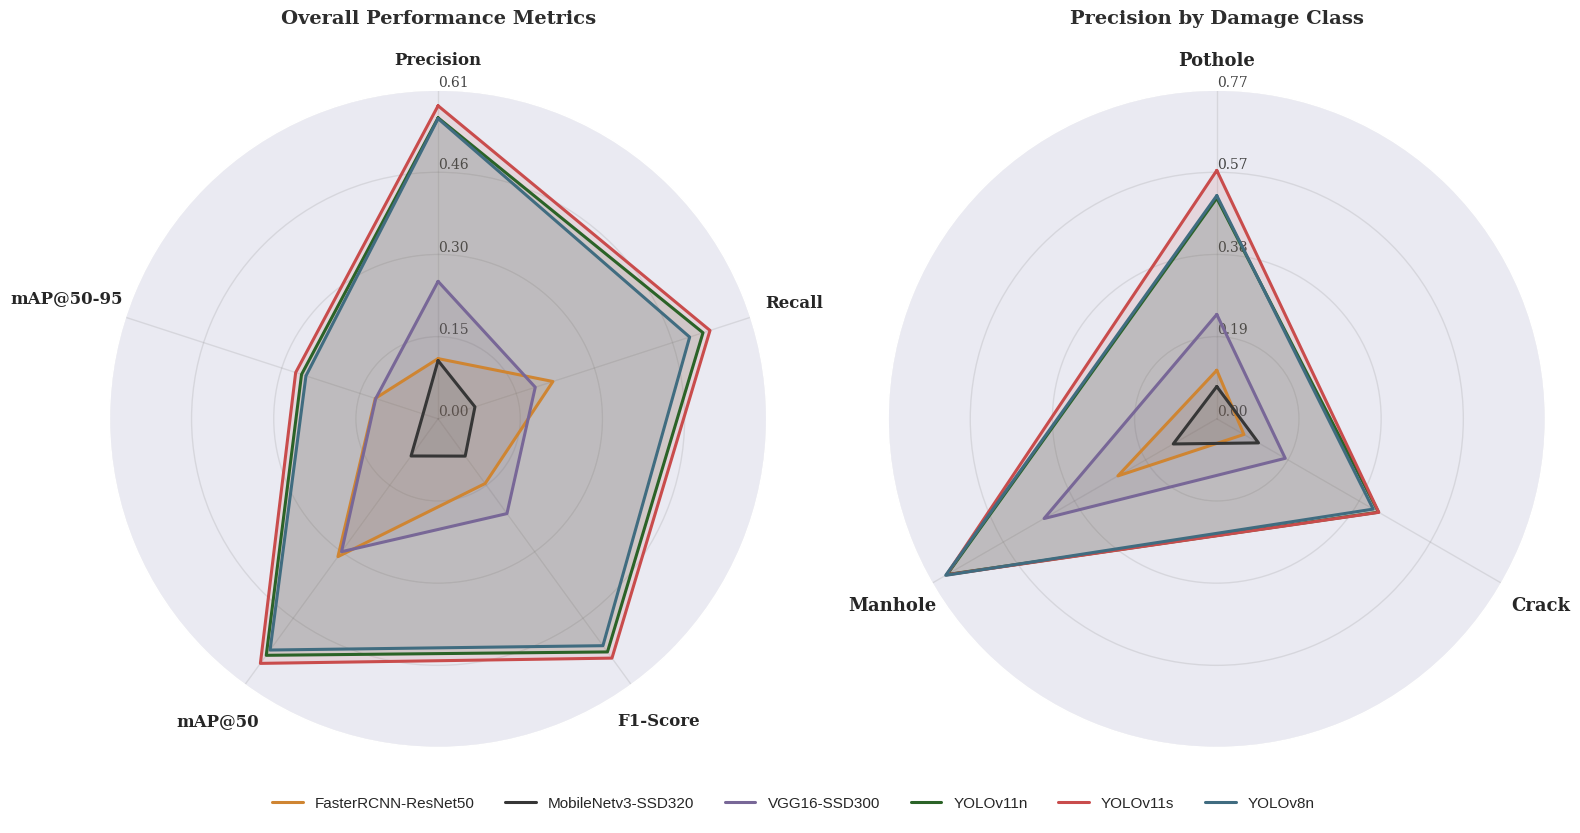

In [4]:
# === SETUP ===
map_metric = 'mAP50' if 'mAP50' in df_mean['metric'].values else 'ap50'
classes = ['pothole', 'crack', 'manhole']
metrics = ['precision', 'recall', 'f1', map_metric, 'mAP']
metric_labels = ['Precision', 'Recall', 'F1-Score', 'mAP@50', 'mAP@50-95']

df_precision = df_classes[df_classes['metric'] == 'precision'].copy()

# Angoli per i radar
num_classes = len(classes)
num_metrics = len(metrics)
angles_classes = np.linspace(0, 2 * np.pi, num_classes, endpoint=False).tolist()
angles_classes += angles_classes[:1]
angles_metrics = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles_metrics += angles_metrics[:1]

# Valori massimi dinamici
max_val_metrics = float(df_mean['value'].max()) * 1.05
max_val_classes = float(df_precision['value'].max()) * 1.05

# === FIGURA COMBINATA ===
fig = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')

# === SUBPLOT 1: OVERALL METRICS ===
ax1 = plt.subplot(121, polar=True)

# Configurazione griglia
ax1.set_theta_offset(np.pi / 2)
ax1.set_theta_direction(-1)
ax1.set_rlabel_position(0)
ax1.set_ylim(0, max_val_metrics)

# Etichette assi
ax1.set_xticks(angles_metrics[:-1])
ax1.set_xticklabels(metric_labels, fontsize=12, fontfamily='serif', fontweight='600')
ax1.set_yticks(np.linspace(0, max_val_metrics, 5))
ax1.set_yticklabels([f"{v:.2f}" for v in np.linspace(0, max_val_metrics, 5)],
                     fontsize=10, fontfamily='serif', color="#444444")
ax1.grid(alpha=0.2, linewidth=1.0, linestyle='-', color='#888888')
ax1.tick_params(axis='x', pad=20)

# Aumenta pad per etichette specifiche
labels = ax1.get_xticklabels()
labels[0].set_position((labels[0].get_position()[0], labels[0].get_position()[1] - 0.03))  # Precision
labels[-1].set_position((labels[-1].get_position()[0], labels[-1].get_position()[1] - 0.05))  # mAP@50-95

# Plot per ogni modello
print("\n=== RADAR CHART VALUES ===")
for model in models:
    print(f"\nModel: {model}")
    values = []
    for metric in metrics:
        val = df_mean[(df_mean['model'] == model) & (df_mean['metric'] == metric)]['value'].values
        v = float(val[0]) if len(val) > 0 else 0
        values.append(v)
        print(f"  {metric}: {v:.4f}")
    
    values += values[:1]
    ax1.plot(angles_metrics, values, linewidth=2.2, linestyle='-',
             color=model_colors[model], label=model)
    ax1.fill(angles_metrics, values, color=model_colors[model], alpha=0.12)

# Titolo
ax1.set_title('Overall Performance Metrics',
              fontsize=14, fontweight='700', fontfamily='serif', 
              pad=20, color='#2d2d2d')

# === SUBPLOT 2: CLASS-SPECIFIC PRECISION ===
ax2 = plt.subplot(122, polar=True)

# Configurazione griglia
ax2.set_theta_offset(np.pi / 2)
ax2.set_theta_direction(-1)
ax2.set_rlabel_position(0)
ax2.set_ylim(0, max_val_classes)

# Etichette assi
ax2.set_xticks(angles_classes[:-1])
ax2.set_xticklabels([cls.capitalize() for cls in classes],
                     fontsize=13, fontfamily='serif', fontweight='600')
ax2.set_yticks(np.linspace(0, max_val_classes, 5))
ax2.set_yticklabels([f"{v:.2f}" for v in np.linspace(0, max_val_classes, 5)],
                     fontsize=10, fontfamily='serif', color="#444444")
ax2.grid(alpha=0.2, linewidth=1.0, linestyle='-', color='#888888')
ax2.tick_params(axis='x', pad=20)

# Aumenta pad per Pothole e Precision
labels = ax1.get_xticklabels()
labels[0].set_position((labels[0].get_position()[0], labels[0].get_position()[1] + 0.08))  # Precision 
labels = ax2.get_xticklabels()
labels[0].set_position((labels[0].get_position()[0], labels[0].get_position()[1] + 0.05))  # Pothole

# Plot per ogni modello
print("\n=== RADAR PRECISION PER CLASSE (VALUES) ===")
for model in models:
    print(f"\nModel: {model}")
    values = []
    for cls in classes:
        val = df_precision[(df_precision['model'] == model) &
                          (df_precision['class'] == cls)]['value'].values
        v = float(val[0]) if len(val) > 0 else 0
        values.append(v)
        print(f"  {cls}: {v:.4f}")
    
    values += values[:1]
    ax2.plot(angles_classes, values, linewidth=2.2, linestyle='-',
             color=model_colors[model], label=model)
    ax2.fill(angles_classes, values, color=model_colors[model], alpha=0.12)

# Titolo
ax2.set_title('Precision by Damage Class',
              fontsize=14, fontweight='700', fontfamily='serif',
              pad=20, color='#2d2d2d')

# === LEGENDA UNICA ===
# Raccogliamo le handles dalla prima subplot (sono identiche per entrambe)
handles, labels = ax1.get_legend_handles_labels()

# Legenda centrata sotto i due subplot
legend = fig.legend(handles, labels, 
                    loc='lower center', 
                    bbox_to_anchor=(0.5, -0.05),
                    ncol=len(models),
                    fontsize=11, 
                    framealpha=1.0, 
                    fancybox=False,
                    edgecolor='#2d2d2d', 
                    borderpad=0.8)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_linewidth(1.2)

plt.tight_layout()
plt.savefig("./results/images/baselines/combined_radar_comparison.png",
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()